In [39]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [40]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [41]:
import dill
import json

with open(DATA_DIR/"setting.json", 'r') as fp:
    _setting = json.load(fp)
_setting_save = _setting["Saving results"]
_setting_data = _setting["Data set selection"]
_setting_qasvm = _setting["SoftQASVM setting"]
_setting_simulator = _setting["Simulator setting"]
_setting_optimizer = _setting["Optimizer setting"]
_setting_rep = _setting["Repetition setting"]

In [42]:
from classifiers.datasets import SklearnDataset
from pandas import read_csv, DataFrame
import random

seed = random.randint(0, 9999)

data = read_csv(DATA_DIR/'sample_summary.csv')

training_data = np.load(DATA_DIR/'Dataset #0/training_data.npy')
test_data = np.load(DATA_DIR/'Dataset #0/test_data.npy')
training_label = np.load(DATA_DIR/'Dataset #0/training_label.npy')
test_label = np.load(DATA_DIR/'Dataset #0/test_label.npy')

ds = SklearnDataset('iris', (-np.pi, np.pi), true_hot=0)#_setting_data['DATA_HOT'])
training_data, training_label, test_data, test_label = ds.sample_training_and_test_dataset((len(training_label), len(test_label)), return_X_y=True, random_state=7913)#, random_state=_setting_rep["SEED"])
print(seed)

1004


In [43]:
C = _setting_qasvm["C"]
lamda = _setting_qasvm["LAMBDA"]

In [44]:
def fval(did, cid, layer, reps):
    with open(DATA_DIR/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

with open(DATA_DIR/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm = dill.load(fp)

training_kernel = _qasvm._qk.evaluate(training_data, training_data)
test_kernel = _qasvm._qk.evaluate(test_data, training_data)

In [45]:
hyperC = 10**np.linspace(-4, 4, 5)
lamdas = 10**np.linspace(-4, 4, 5)
X, Y = np.meshgrid(hyperC, lamdas)
Z = np.empty_like(X)

In [46]:
from classifiers.convex.svm import CvxSoftQASVM
from tqdm import tqdm

with tqdm(total = len(X.flatten())) as pbar:
    for i, _X in enumerate(X):
        for j, _ in enumerate(_X):
            svm = CvxSoftQASVM(kernel='precomputed', C=X[i, j], lamda=Y[i, j])
            svm.fit(training_kernel, training_label)
            accuracy =svm.accuracy(test_kernel, test_label)
            # svm = SVC(C=X[i, j], kernel='rbf')
            # svm.fit(training_data, training_labels[classes[label_index]])
            # accuracy = svm.score(test_data, test_labels[classes[label_index]])
            Z[i, j] = accuracy
            pbar.update()

100%|██████████| 25/25 [00:00<00:00, 632.71it/s]


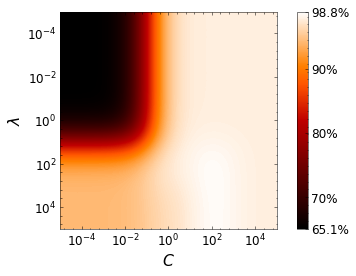

In [85]:
with plt.rc_context():
    fig, ax = plt.subplots()
    cs = ax.imshow(Z, interpolation='gaussian', cmap='gist_heat')
    # for i in range(Z.shape[0]):
    #     for j in range(Z.shape[1]):
    #         c = Z[j, i]
    #         ax.text(i, j, '{:.1%}'.format(c), va='center', ha='center')
    ax.set_xlabel(r'$C$', fontsize=1.3*plt.rcParams['font.size'])
    ax.set_ylabel(r'$\lambda$', fontsize=1.3*plt.rcParams['font.size'])
    ax.set_xticks(np.arange(len(hyperC)))
    ax.set_xticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(hyperC))))
    ax.set_yticks(np.arange(len(lamdas)))
    ax.set_yticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(lamdas))))
    # ax.set_title('iris accuracy')
    cbar = fig.colorbar(cs, ticks=[np.min(Z), 0.7, 0.8, 0.9, np.max(Z)]) 
    cbar.ax.set_yticklabels(['{:.1%}'.format(np.min(Z)), '70%', '80%', '90%', '{:.1%}'.format(np.max(Z))])
    fig.tight_layout()

fig.savefig('./figs/hyperparameters.svg', dpi=300)
fig.savefig('./figs/hyperparameters.png', dpi=300)
fig.savefig('./figs/hyperparameters.pdf', dpi=300)

In [91]:
np.linalg.cond(training_kernel)

55560.96721236932

In [ ]:
np.linalg.eigvals(training_kernel)